In [2]:
from IPython.display import Image
%matplotlib inline

# import matplotlib.pyplot as plt
# import json
# import collections
# from pymatgen.core.structure import Structure
# from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer, \
#     get_arrhenius_plot, get_extrapolated_conductivity
# from pymatgen_diffusion.aimd.pathway import ProbabilityDensityAnalysis
# # from pymatgen_diffusion.aimd.van_hove import VanHoveAnalysis
# from pymatgen.core.trajectory import Trajectory
# from tqdm import tqdm

from pymatgen.core.structure import Structure, Composition
from pymatgen.io.vasp.outputs import Xdatcar
from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer, get_extrapolated_conductivity, get_arrhenius_plot,get_extrapolated_diffusivity,fit_arrhenius
from pymatgen.analysis.diffusion.aimd.van_hove import VanHoveAnalysis
from pymatgen.analysis.diffusion.aimd.rdf import RadialDistributionFunction, RadialDistributionFunctionFast
# from ovito.io import import_file
# from ovito.modifiers import CoordinationAnalysisModifier
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm
import scipy.constants as const
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import rcParams 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.serif'] = 'Times New Roman'
rcParams['axes.labelsize'] = 18 
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2
rcParams['axes.linewidth'] = 2 #设置坐标轴的粗细
rcParams['axes.prop_cycle'] = (cycler(color=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]))

In [3]:
def get_arrhenius_plot(temps, diffusivities, diffusivity_errors=None, **kwargs):
    r"""
    Returns an Arrhenius plot.
    Args:
        temps ([float]): A sequence of temperatures.
        diffusivities ([float]): A sequence of diffusivities (e.g.,
            from DiffusionAnalyzer.diffusivity).
        diffusivity_errors ([float]): A sequence of errors for the
            diffusivities. If None, no error bar is plotted.
        \\*\\*kwargs:
            Any keyword args supported by matplotlib.pyplot.plot.
    Returns:
        A matplotlib.pyplot object. Do plt.show() to show the plot.
    """
    Ea, c, _ = fit_arrhenius(temps, diffusivities)
    import matplotlib.pyplot as plt
    from cycler import cycler
    from matplotlib import rcParams 
    rcParams['font.serif'] = 'Times New Roman'
    rcParams['axes.labelsize'] = 18 
    rcParams['font.size'] = 14
    rcParams['lines.linewidth'] = 2
    rcParams['axes.linewidth'] = 2 #设置坐标轴的粗细
    rcParams['axes.prop_cycle'] = (cycler(color=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]))
    fig, ax = plt.subplots(figsize=(8,6))
    # log10 of the arrhenius fit
    arr = c * np.exp(-Ea / (const.k / const.e * np.array(temps)))
    t_1 = 1000 / np.array(temps)
    ax.plot(t_1, np.log(diffusivities), 'rs', markersize=10) 
    ax.plot(t_1, np.log(arr), color='blue', linestyle='-')
    if diffusivity_errors is not None:
        n = len(diffusivity_errors)
        plt.errorbar(
            t_1[0:n],
            np.log(diffusivities[0:n]),
            yerr=diffusivity_errors,
            fmt='o', ms=10, mfc='r', mec='r', ecolor='r', capsize=5, capthick=2, elinewidth=2,
        )
    # ax = plt.axes()
    # ax.set_yscale("log")
    ax.text(
        0.55,
        0.85,
        "E$_a$ = {} ± {}meV".format(round(Ea*1000,1),round(_*1000,1)),
        fontsize=14,
        transform = ax.transAxes,
    )
    ax.set_ylabel("ln(D (cm$^2$/s))")
    ax.set_xlabel("1000/T (K$^{-1}$)")
    plt.tight_layout()
    return plt

In [4]:
M1 = ['Al','Ga','In']
M2 = ['I','Se','S']
# i = M1[1]
# j = M2[1]
m1 = M1[0]
m2 = M2[2]
system = 'Y-Se' #f"{m1}-Te-{m2}" structure-Al-B-Ga-Si-Sn-Ge/3/
li_num = 8
min_obs = li_num*3  #表示把msd分成三段取平均，减小误差
time_step = 2  # in fs
temperatures = [300,900,1100,1300,1500]#,1100,1300,1500]# 900,1050,950 [900,950,1000,1050,1100,1300,1500,1700] #1200K_new,1350K_new
analyzers = collections.OrderedDict()
len_xdatcar = 20000
ionicstep_start = 1
ionicstep_end = 50000
step_skip = 1 #与time_step的乘积代表每一步的真实时间，一般取1
aimd_type='aimd_50000'
compund_type = 'LiM_MO3_2' #'NASICON' #'Li_candidate'#'LiM_MO3_2'

In [5]:
V = ['Nb','Sb','Ta']
II = ['Mg','Ca','Sr']
VI = ['Te','Mo','W']
III = ['Sc','Y','La','Al','Ga','In','Cr','Fe']
IV = ['Hf','Zr','Ti','Ge','Sn','Si']
# i = M1[1]
# j = M2[1]
m1 = IV[0]
m2 = IV[1]
system = f'structure-{m1}-{m2}-1' #f"{m1}-Te-{m2}" structure-Al-B-Ga-Si-Sn-Ge/3/
li_num = 2
min_obs = li_num*3  #表示把msd分成三段取平均，减小误差
time_step = 2  # in fs
temperatures = [1100,1300,1500]#,1100,1300,1500]# 900,1050,950 [900,950,1000,1050,1100,1300,1500,1700] #1200K_new,1350K_new
analyzers = collections.OrderedDict()
len_xdatcar = 20000
ionicstep_start = 1
ionicstep_end = 20000
step_skip = 1 #与time_step的乘积代表每一步的真实时间，一般取1
aimd_type='aimd_Li'
compund_type = 'NASICON' #'NASICON' #'Li_candidate'#'LiM_MO3_2'

In [6]:
name_dict = {"Al-S":r"LiAl(SO$_3$)$_2$",
 "Al-Se" :  r"LiAl(SeO$_3$)$_2$",
 "Ga-S": r"LiGa(SO$_3$)$_2$",
 "Ga-Se":r"LiGa(SeO$_3$)$_2$",
 "In-S":r"LiIn(SO$_3$)$_2$" ,
 "In-Se":r"LiIn(SeO$_3$)$_2$" ,
 "Sc-S":r"LiSc(SO$_3$)$_2$",
 "Sc-Se":r"LiSc(SeO$_3$)$_2$",
 "Y-S": r"LiY(SO$_3$)$_2$",
 "Y-Se":r"LiY(SeO$_3$)$_2$",
 "La-S":r"LiLa(SO$_3$)$_2$" ,
 "La-Se":r"LiLa(SeO$_3$)$_2$"}

In [7]:
structures = {}

analyzers = collections.OrderedDict()
for temp in tqdm(temperatures):
    print(f'Reading {temp}K XDATCAR file')
    structures[temp] = Xdatcar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/{temp}/XDATCAR',ionicstep_start=ionicstep_start, ionicstep_end=ionicstep_end).structures
    analyzers[temp] = DiffusionAnalyzer.from_structures(structures[temp], specie="Li", temperature=temp, time_step=time_step, step_skip=step_skip, smoothed=True, min_obs=min_obs)

  0%|          | 0/3 [00:00<?, ?it/s]

Reading 1100K XDATCAR file


 33%|███▎      | 1/3 [00:18<00:36, 18.49s/it]

Reading 1300K XDATCAR file


 67%|██████▋   | 2/3 [00:38<00:19, 19.13s/it]

Reading 1500K XDATCAR file


100%|██████████| 3/3 [00:57<00:00, 19.20s/it]


In [392]:
# for temp in tqdm(temperatures):
#     print(f'Reading {temp}K XDATCAR file')
#     structures[temp] = Xdatcar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/{temp}/XDATCAR',ionicstep_start=ionicstep_start, ionicstep_end=ionicstep_end).structures
#     analyzers[temp] = DiffusionAnalyzer.from_structures(structures[temp], specie="Li", temperature=temp, time_step=time_step, step_skip=step_skip, smoothed=False, min_obs=min_obs)

# generate MTP vasp

In [8]:
# import os,subprocess
# n = 0
# for temp in tqdm(temperatures):
#     # os.mkdir(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/MTP/{n}/')
#     for stru in structures[temp][0:-1:200]:
#         subprocess.run(f'mkdir -p /lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/MTP/{n}/',shell=True)
#         stru.to(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/MTP/{n}/POSCAR',fmt='poscar')
#         n = n+1

In [9]:
Li_Li_distance = []
rdf_data = {}
r_data = {}
for temp in temperatures:
    m = structures[temp][0:-1:100]
    rdf_func_faster = RadialDistributionFunctionFast(structures=m, ngrid=1001, rmax=10.0, sigma=0.2)
    r_data[temp], rdf_data[temp] = rdf_func_faster.get_rdf('Li',"Li")
    r_data[temp] = r_data[temp].tolist()
    rdf_data[temp] = rdf_data[temp].tolist()
    Li_Li_distance.append(r_data[temp][rdf_data[temp].index(max(rdf_data[temp]))])

In [10]:
# len(structures[1500])

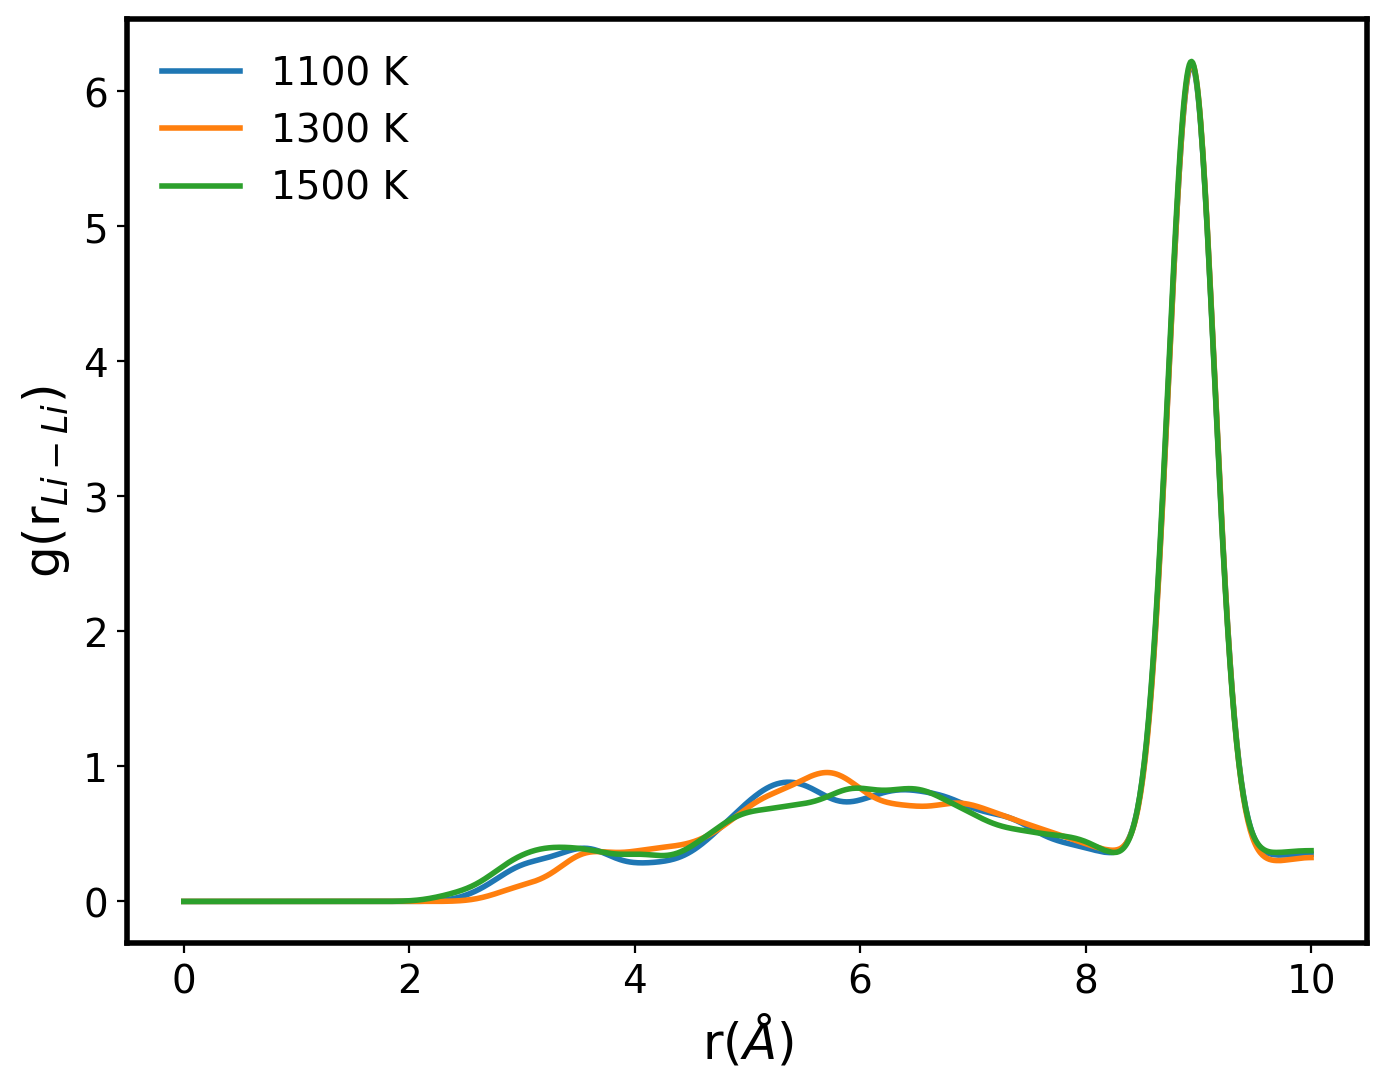

In [11]:

# temp1 = 1700
# m1 = 'In'
# m2 = 'Se'
fig = plt.figure(figsize=(8,6)) #设置画布大小

for temp in temperatures:
    plt.plot(r_data[temp], rdf_data[temp],label=f'{temp} K',linewidth=2)

plt.ylabel("g(r$_{Li - Li}$)")
plt.xlabel("r($\\AA$)")

plt.legend(loc=0,frameon=False)

plt.savefig(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/Li-Li-distance.png', dpi=600, format='png', bbox_inches='tight')

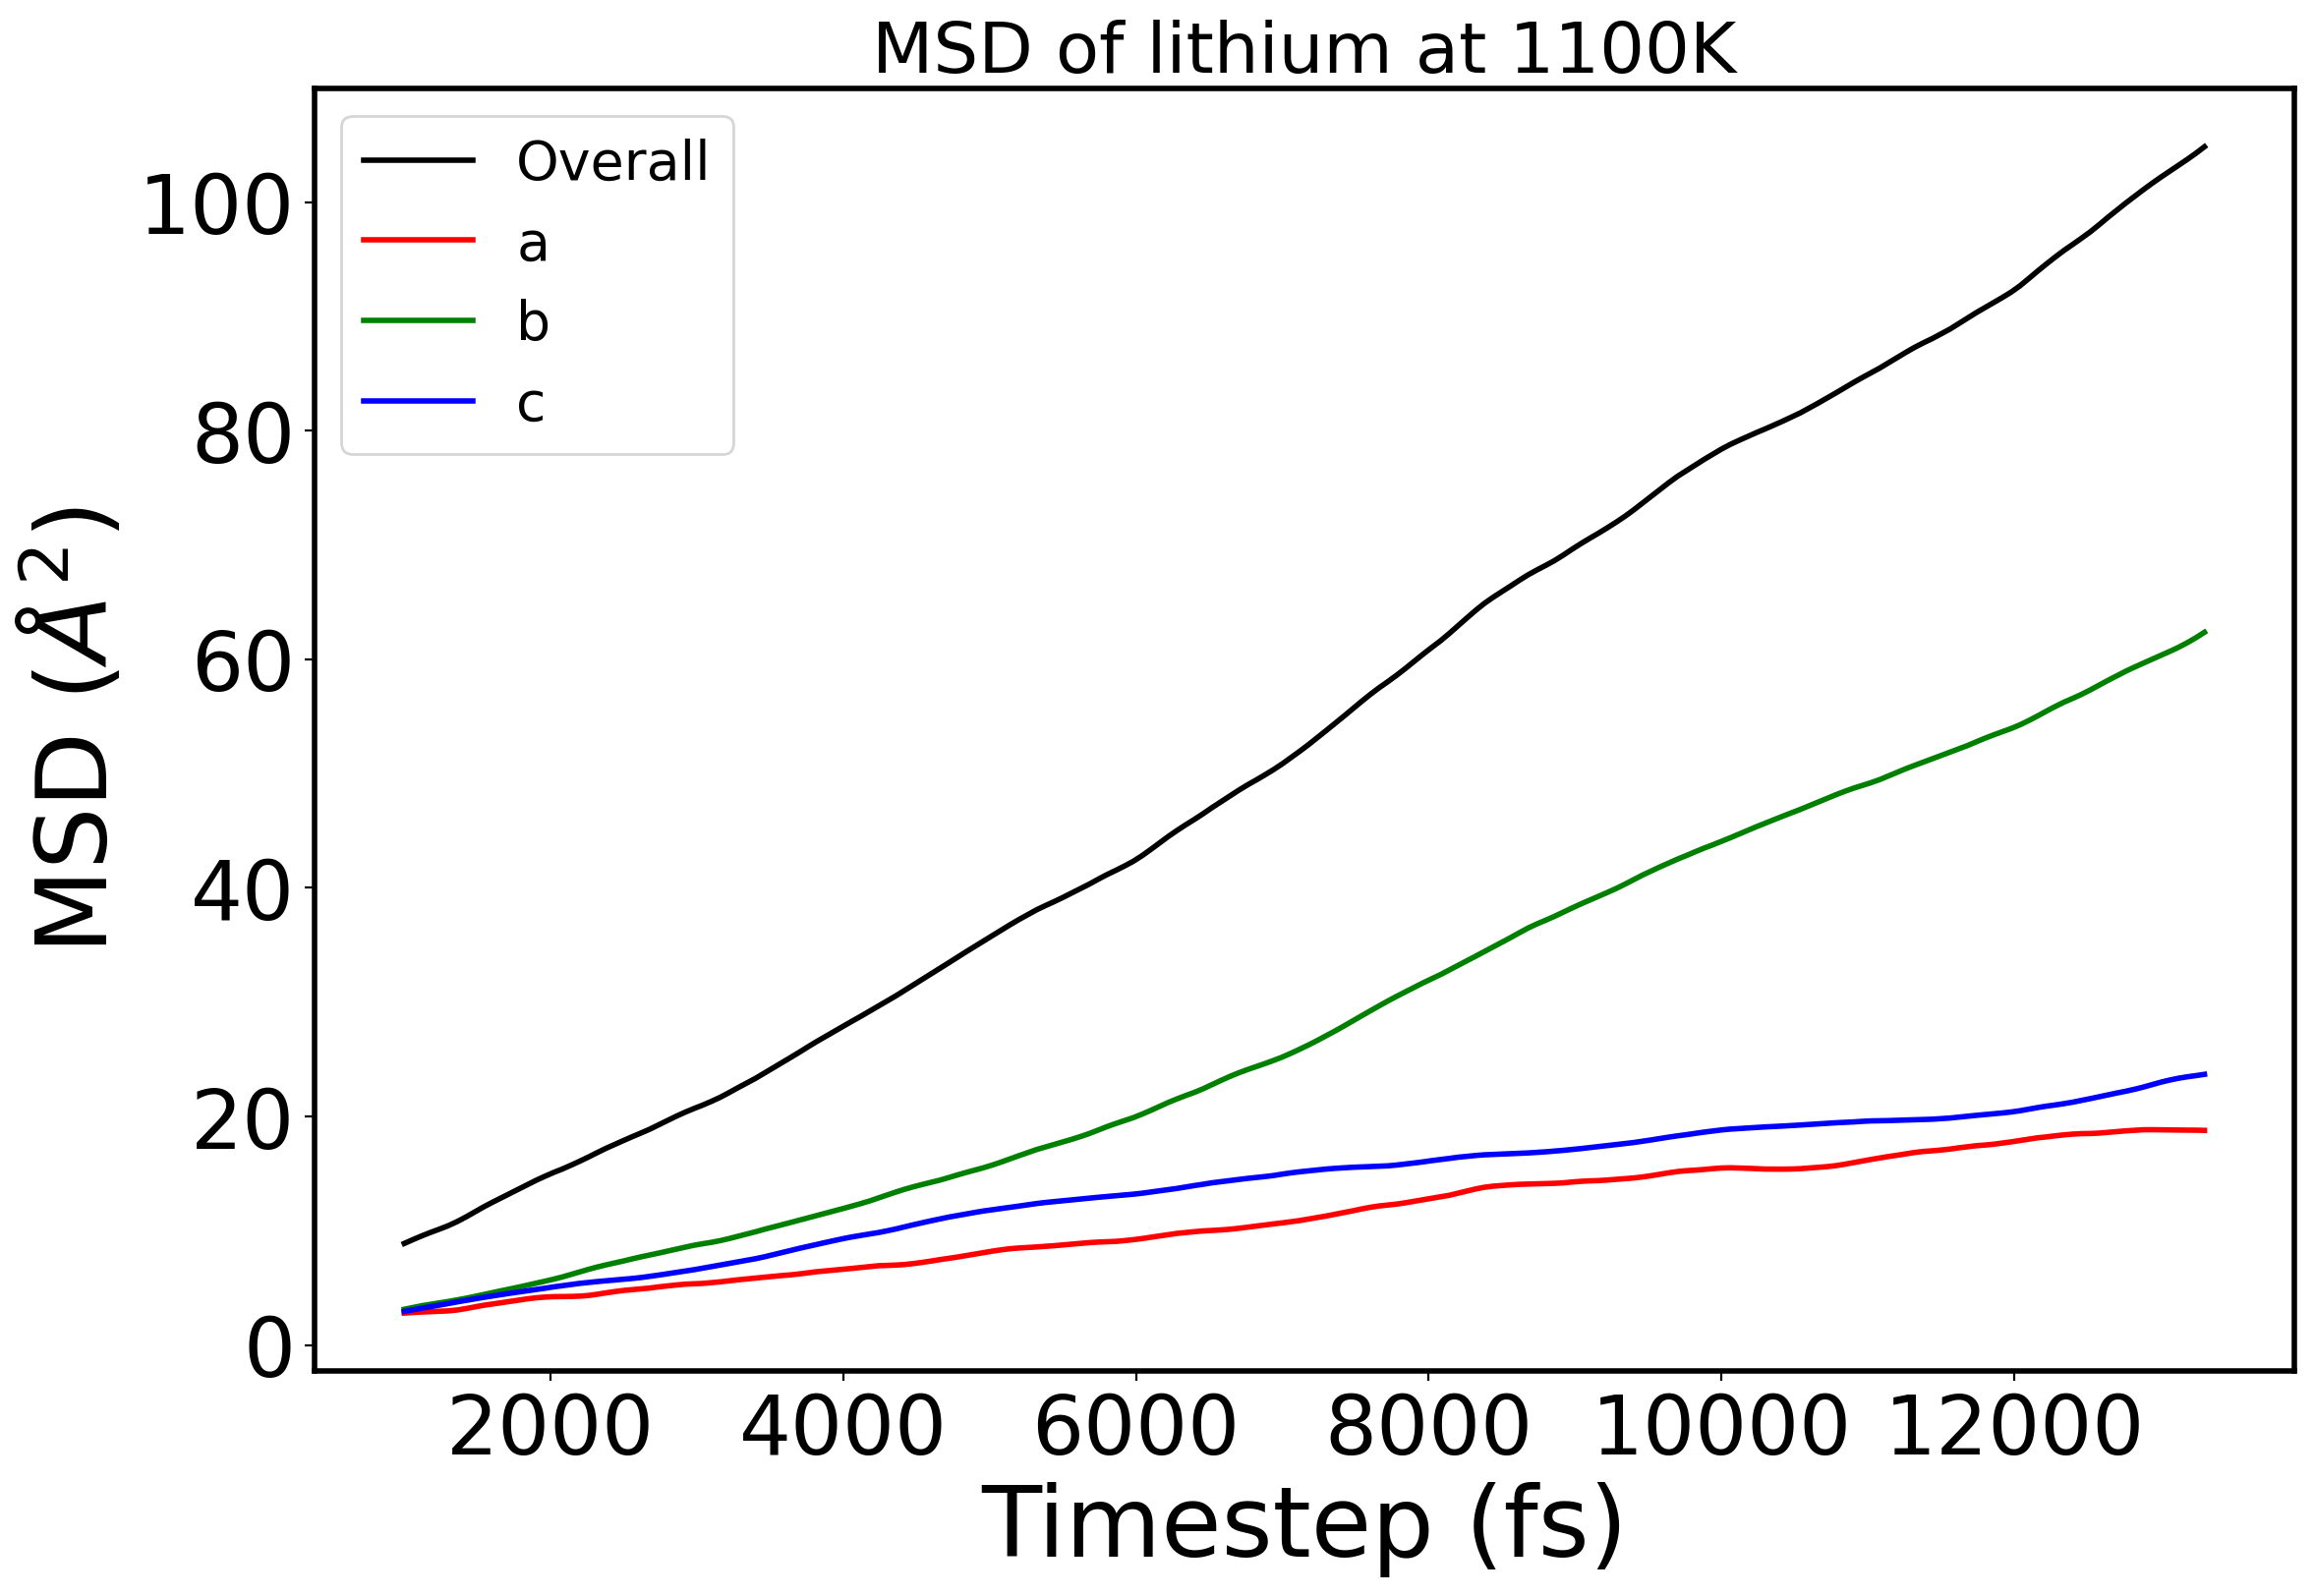

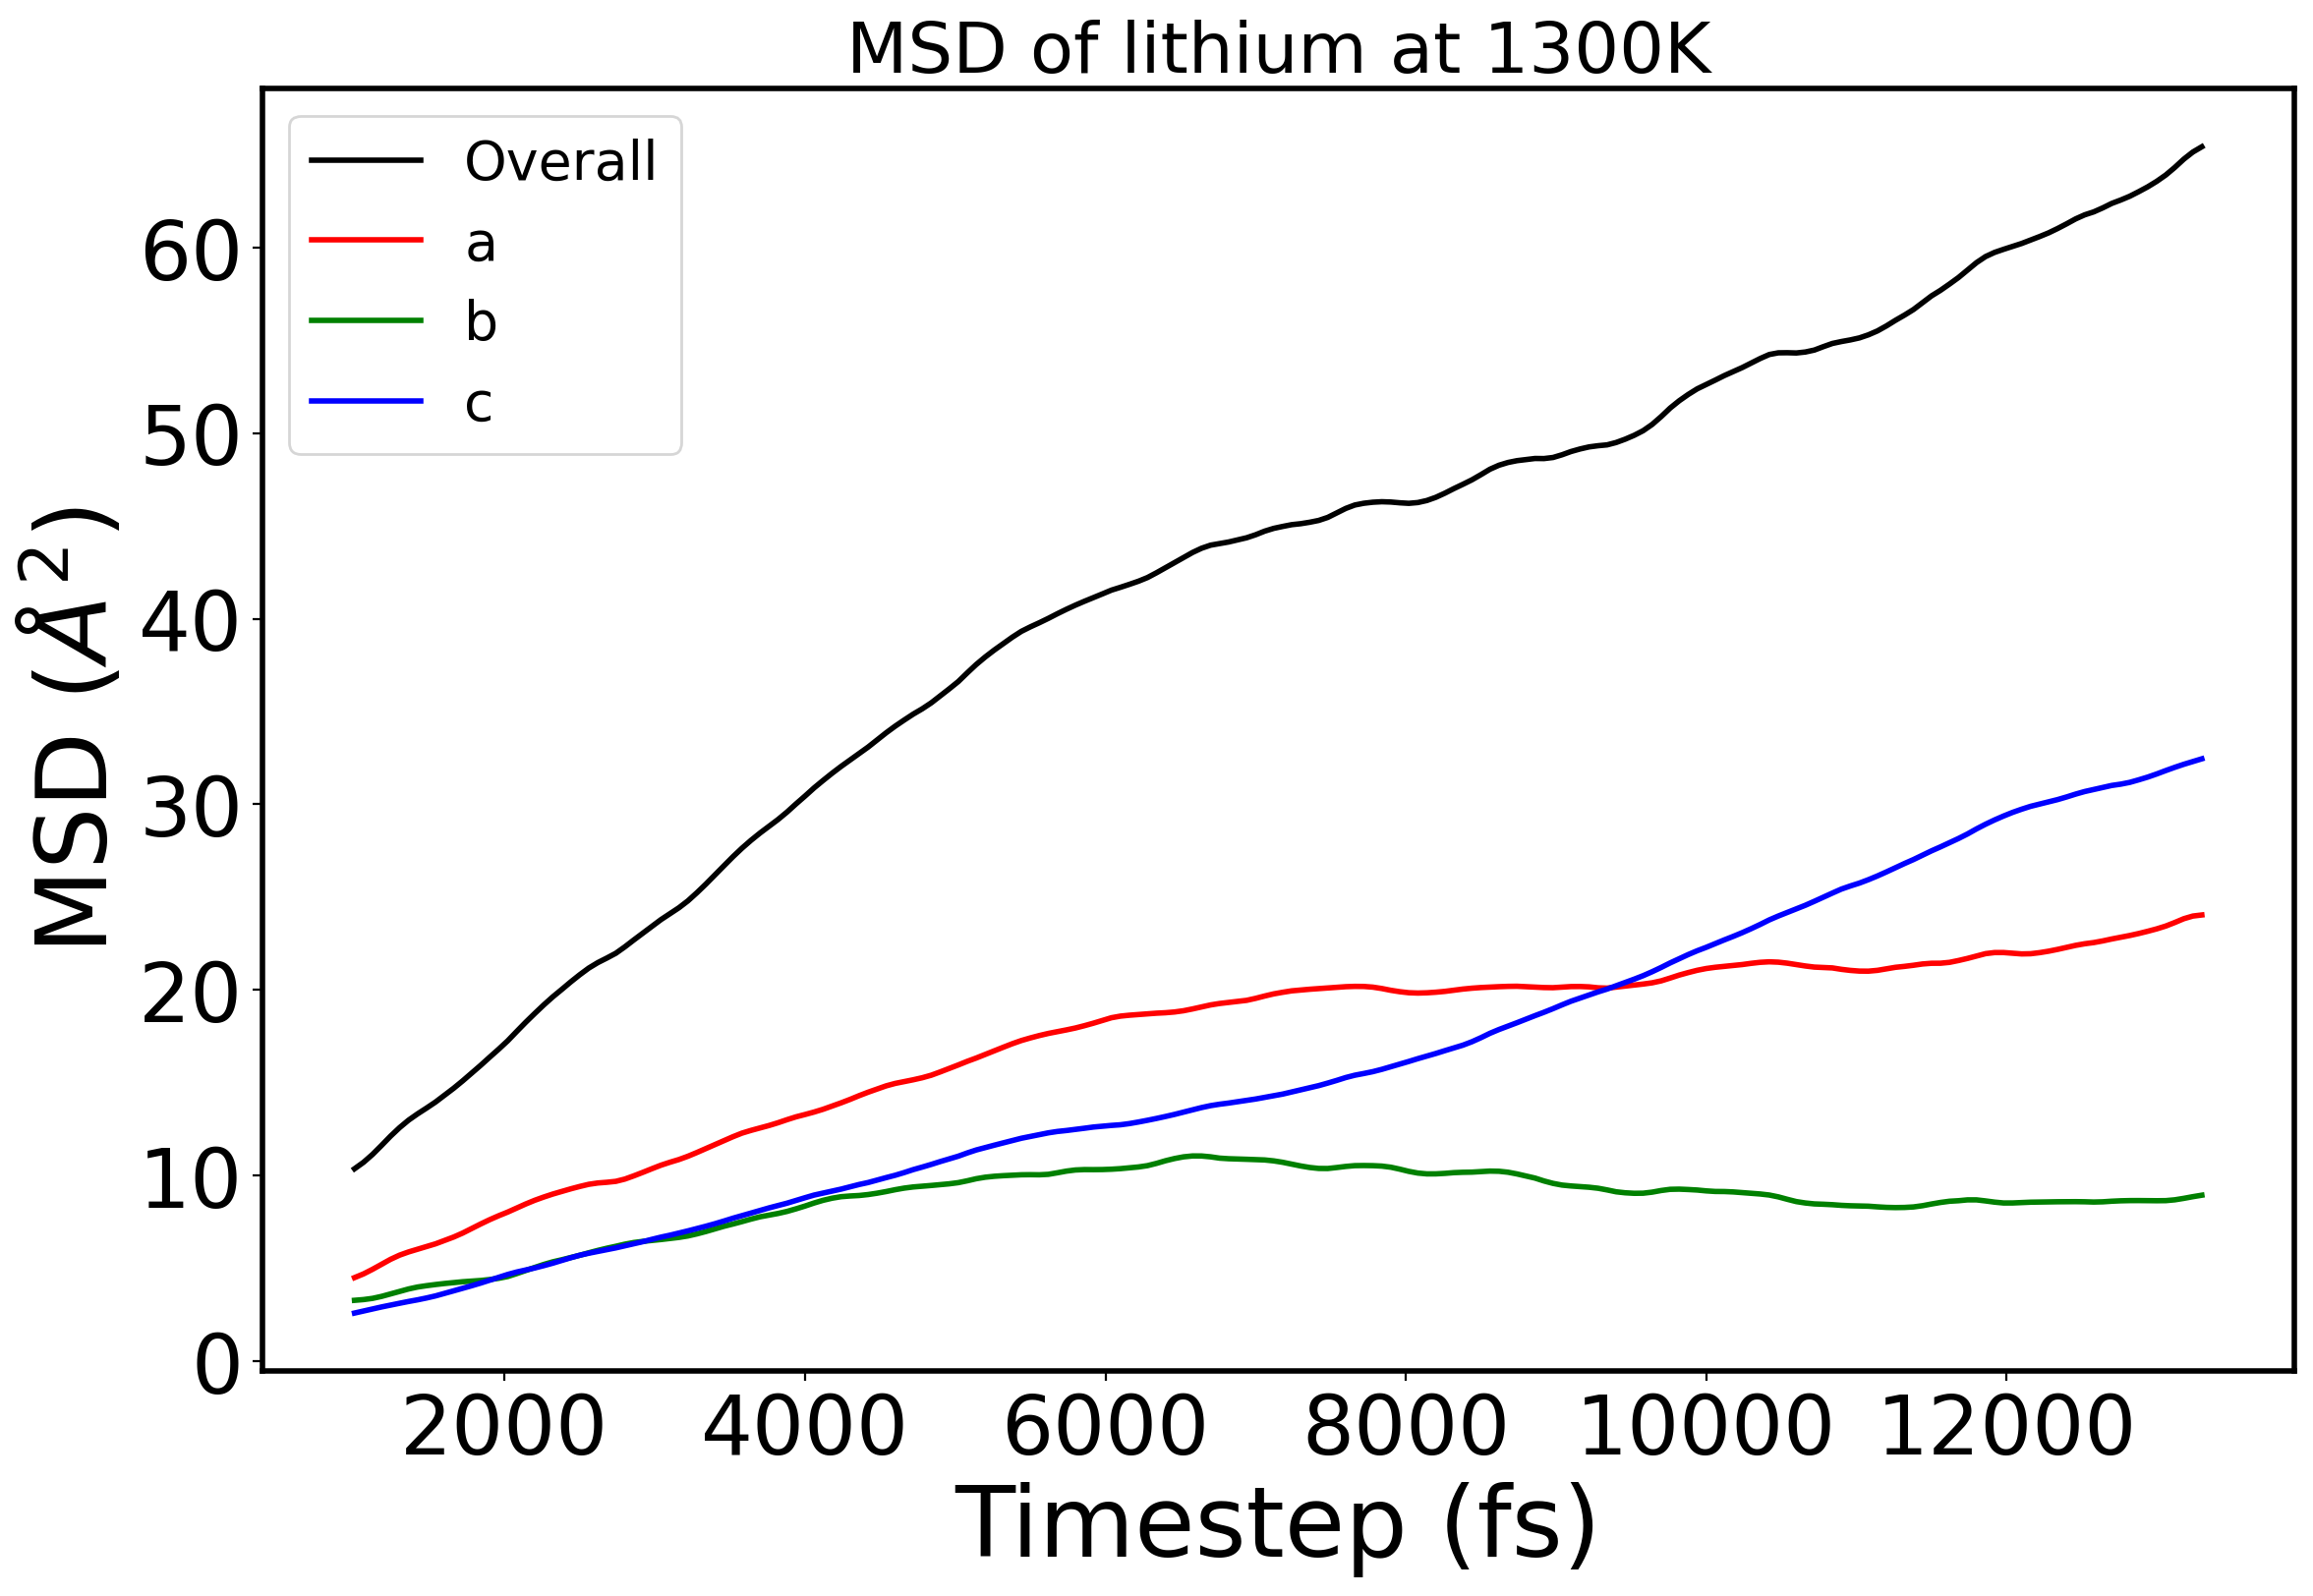

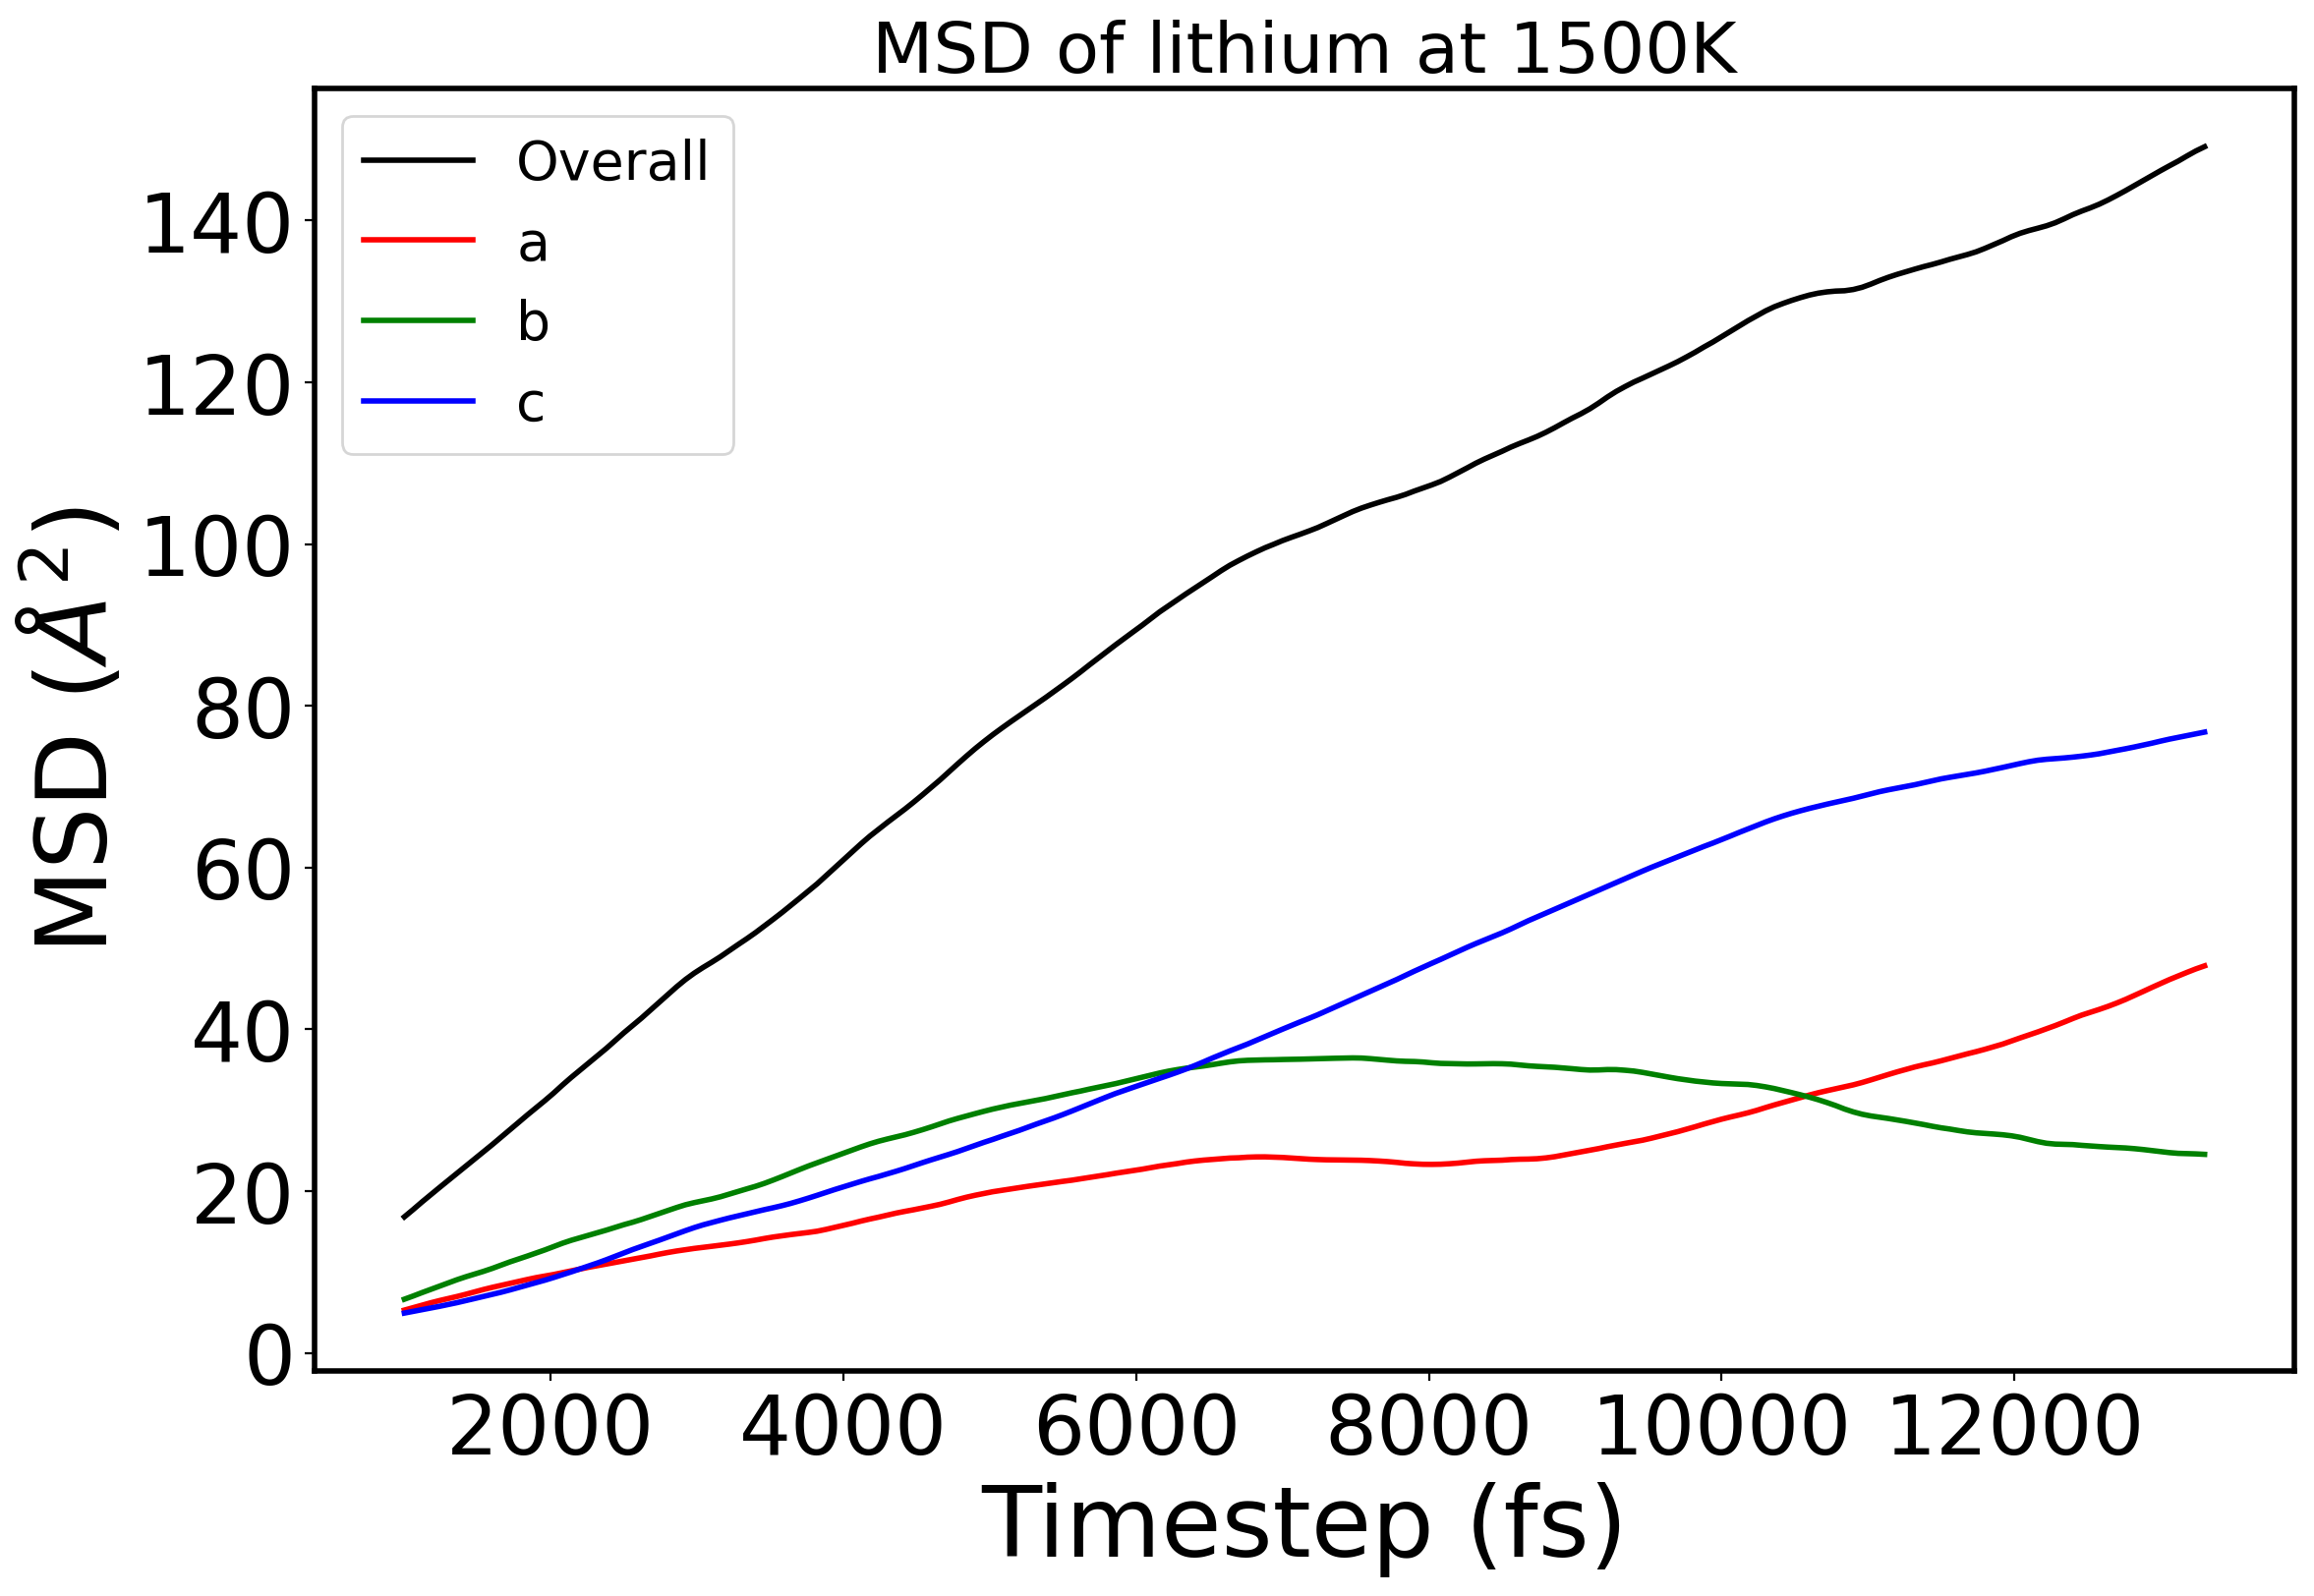

In [12]:
for temp in temperatures:
    # temp=900
    plt = analyzers[temp].get_msd_plot(mode="specie")  # mode="sites"
    plt.title("MSD of lithium at {}K".format(temp), fontsize=26)
    plt.savefig(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/msd_{temp}K_smooth.png', bbox_inches='tight', dpi=600, format='png')
#     analyzers[temp].export_msdt(f'2021-12-30_data/{system}/msd_{temp}K.txt')

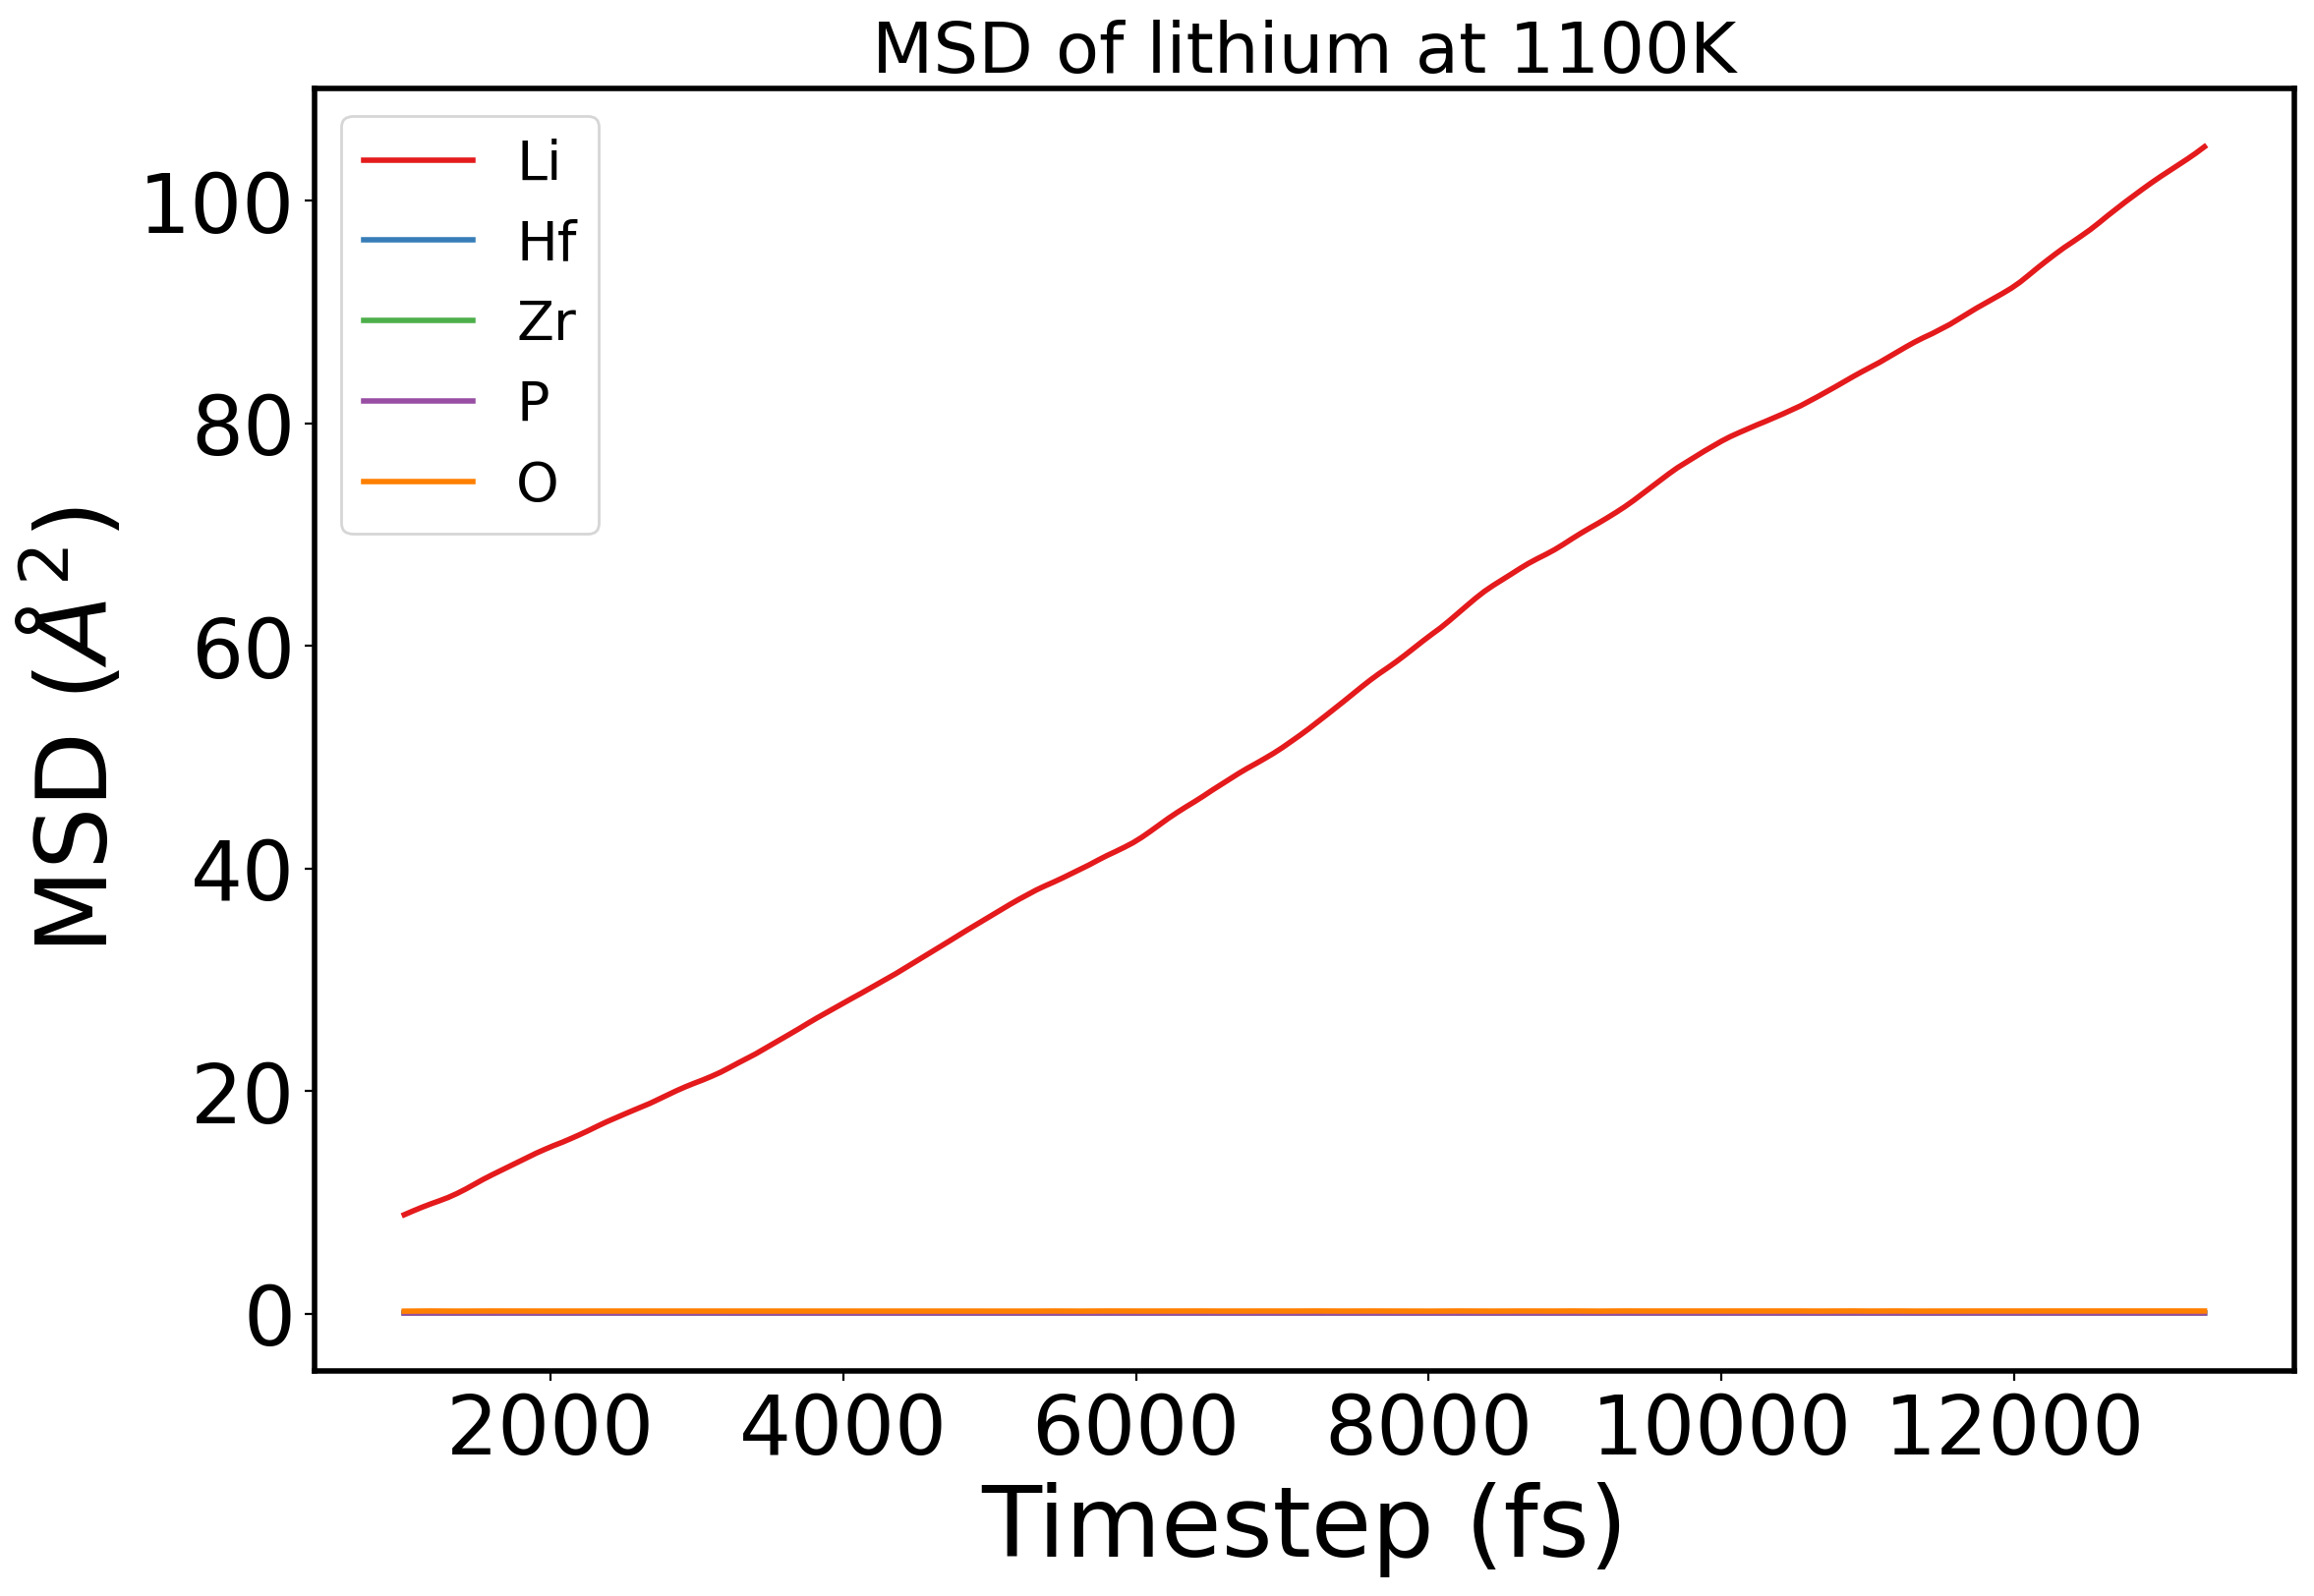

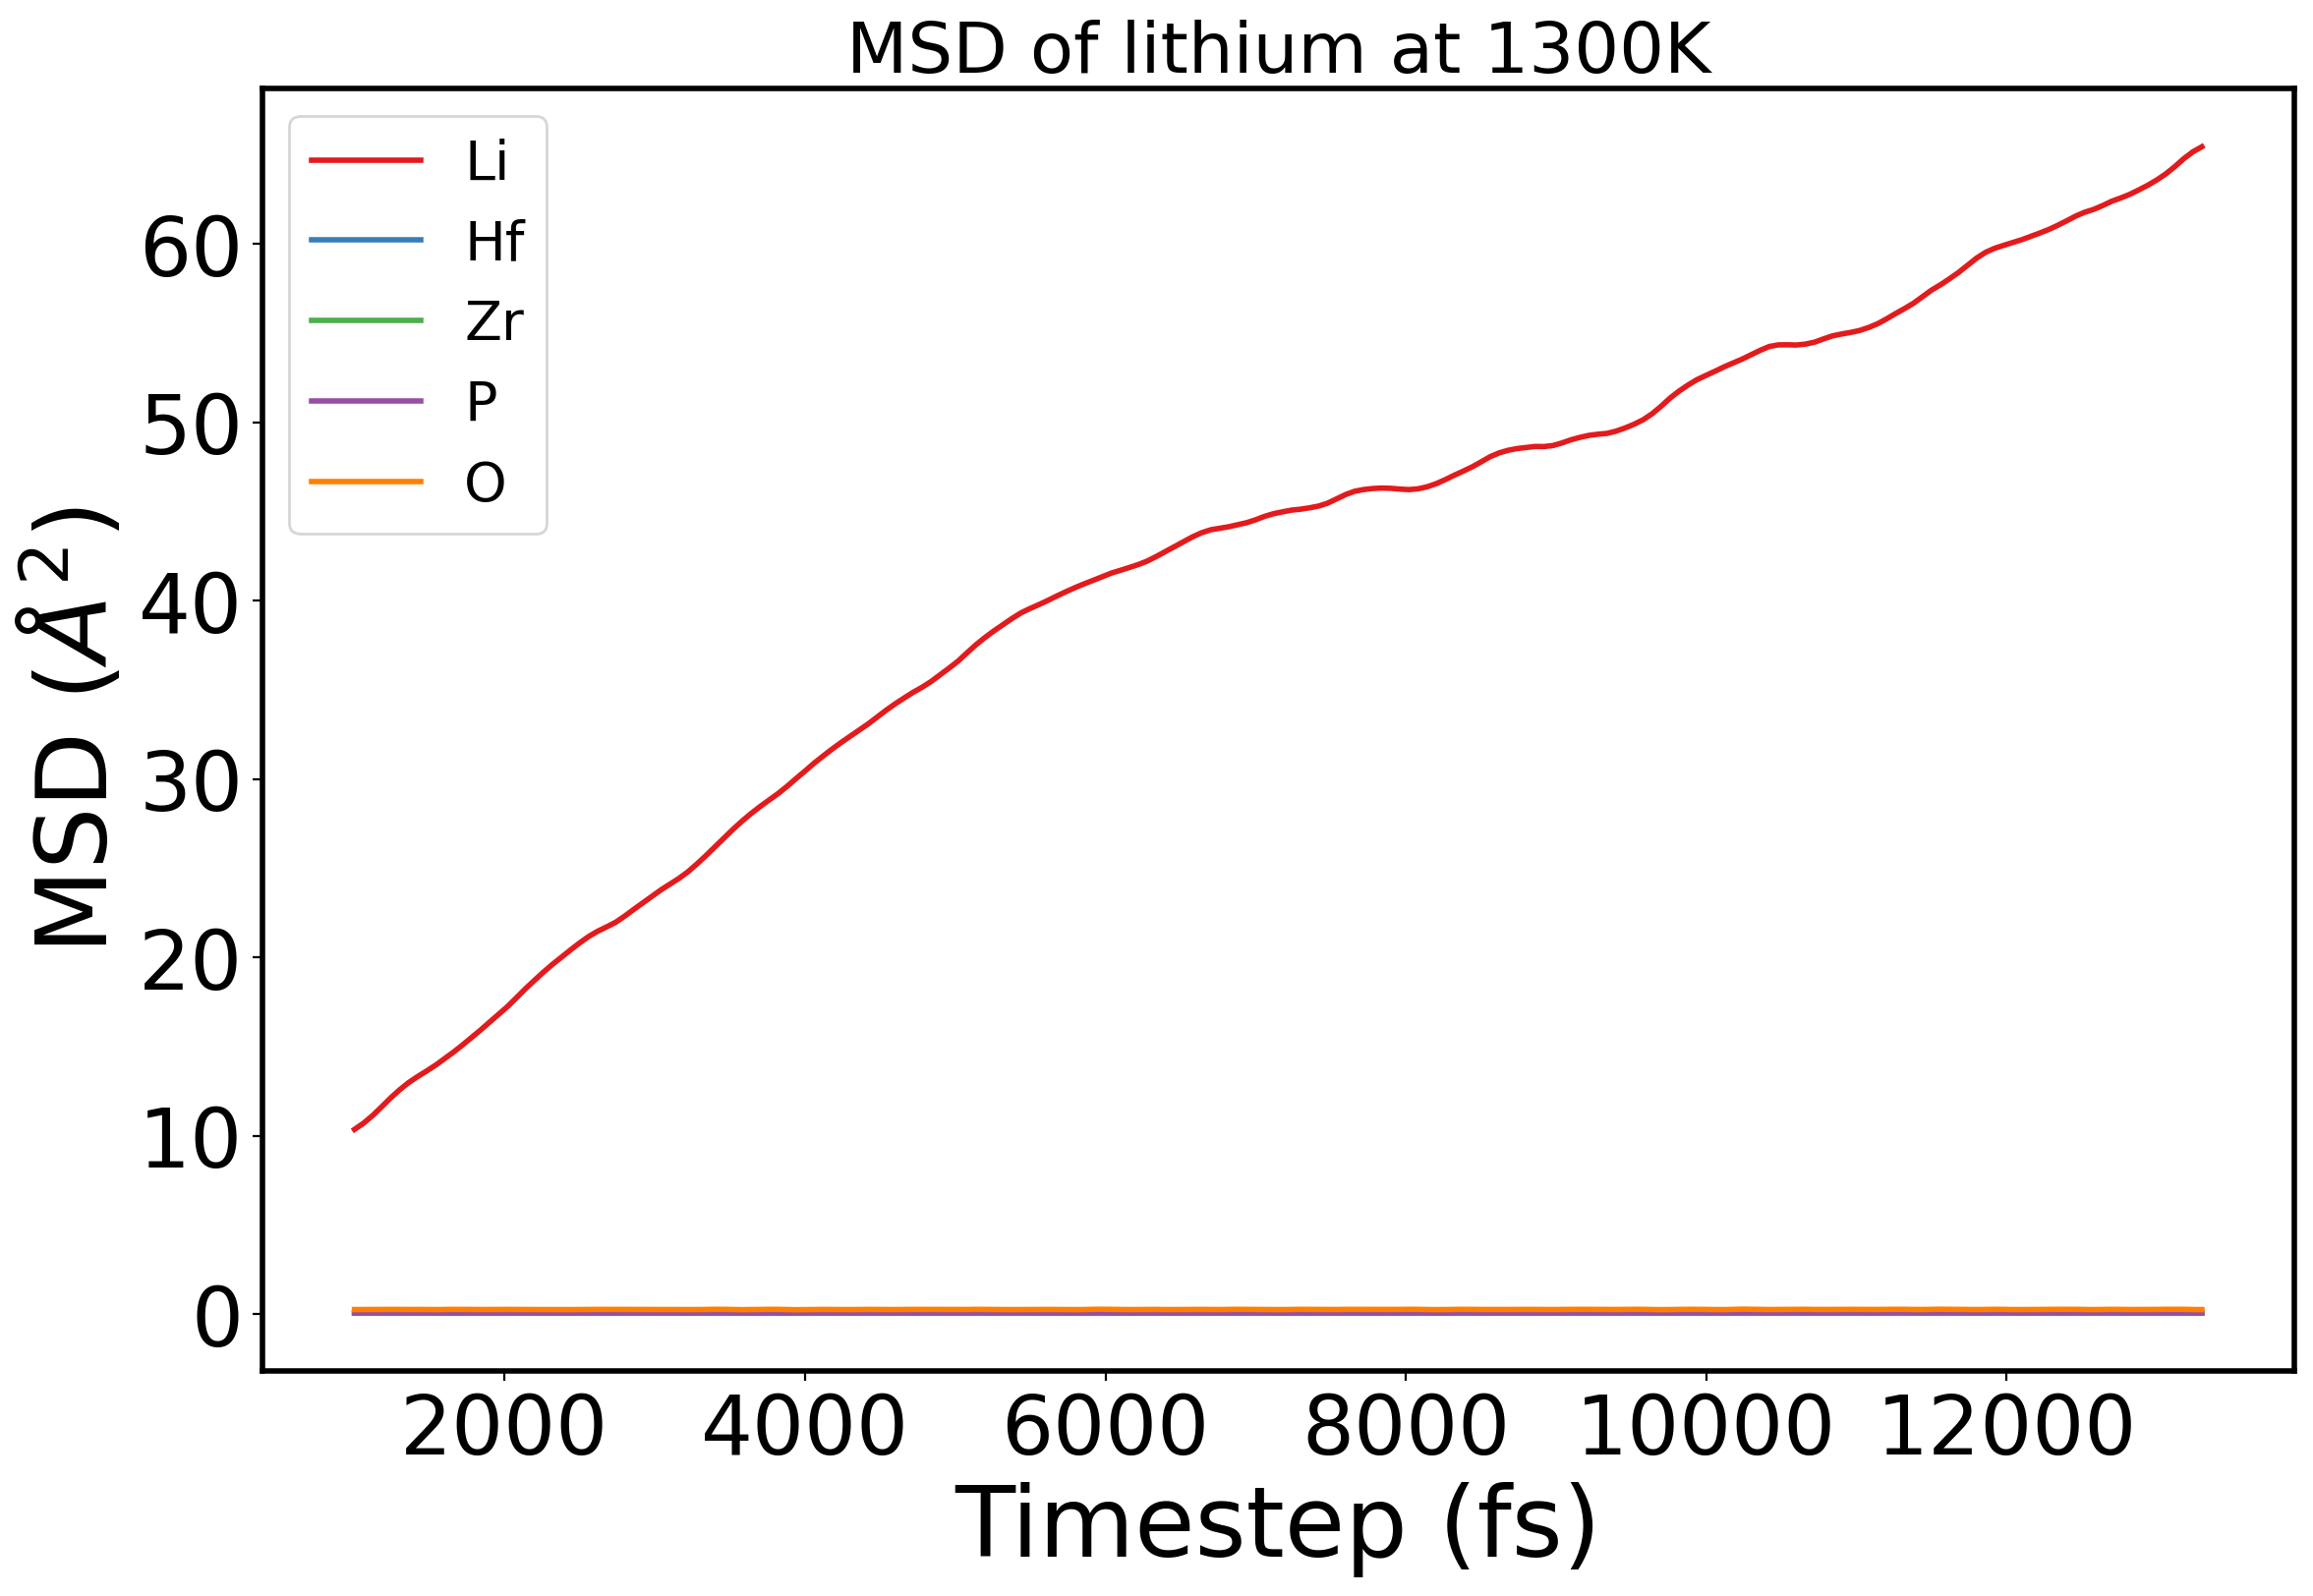

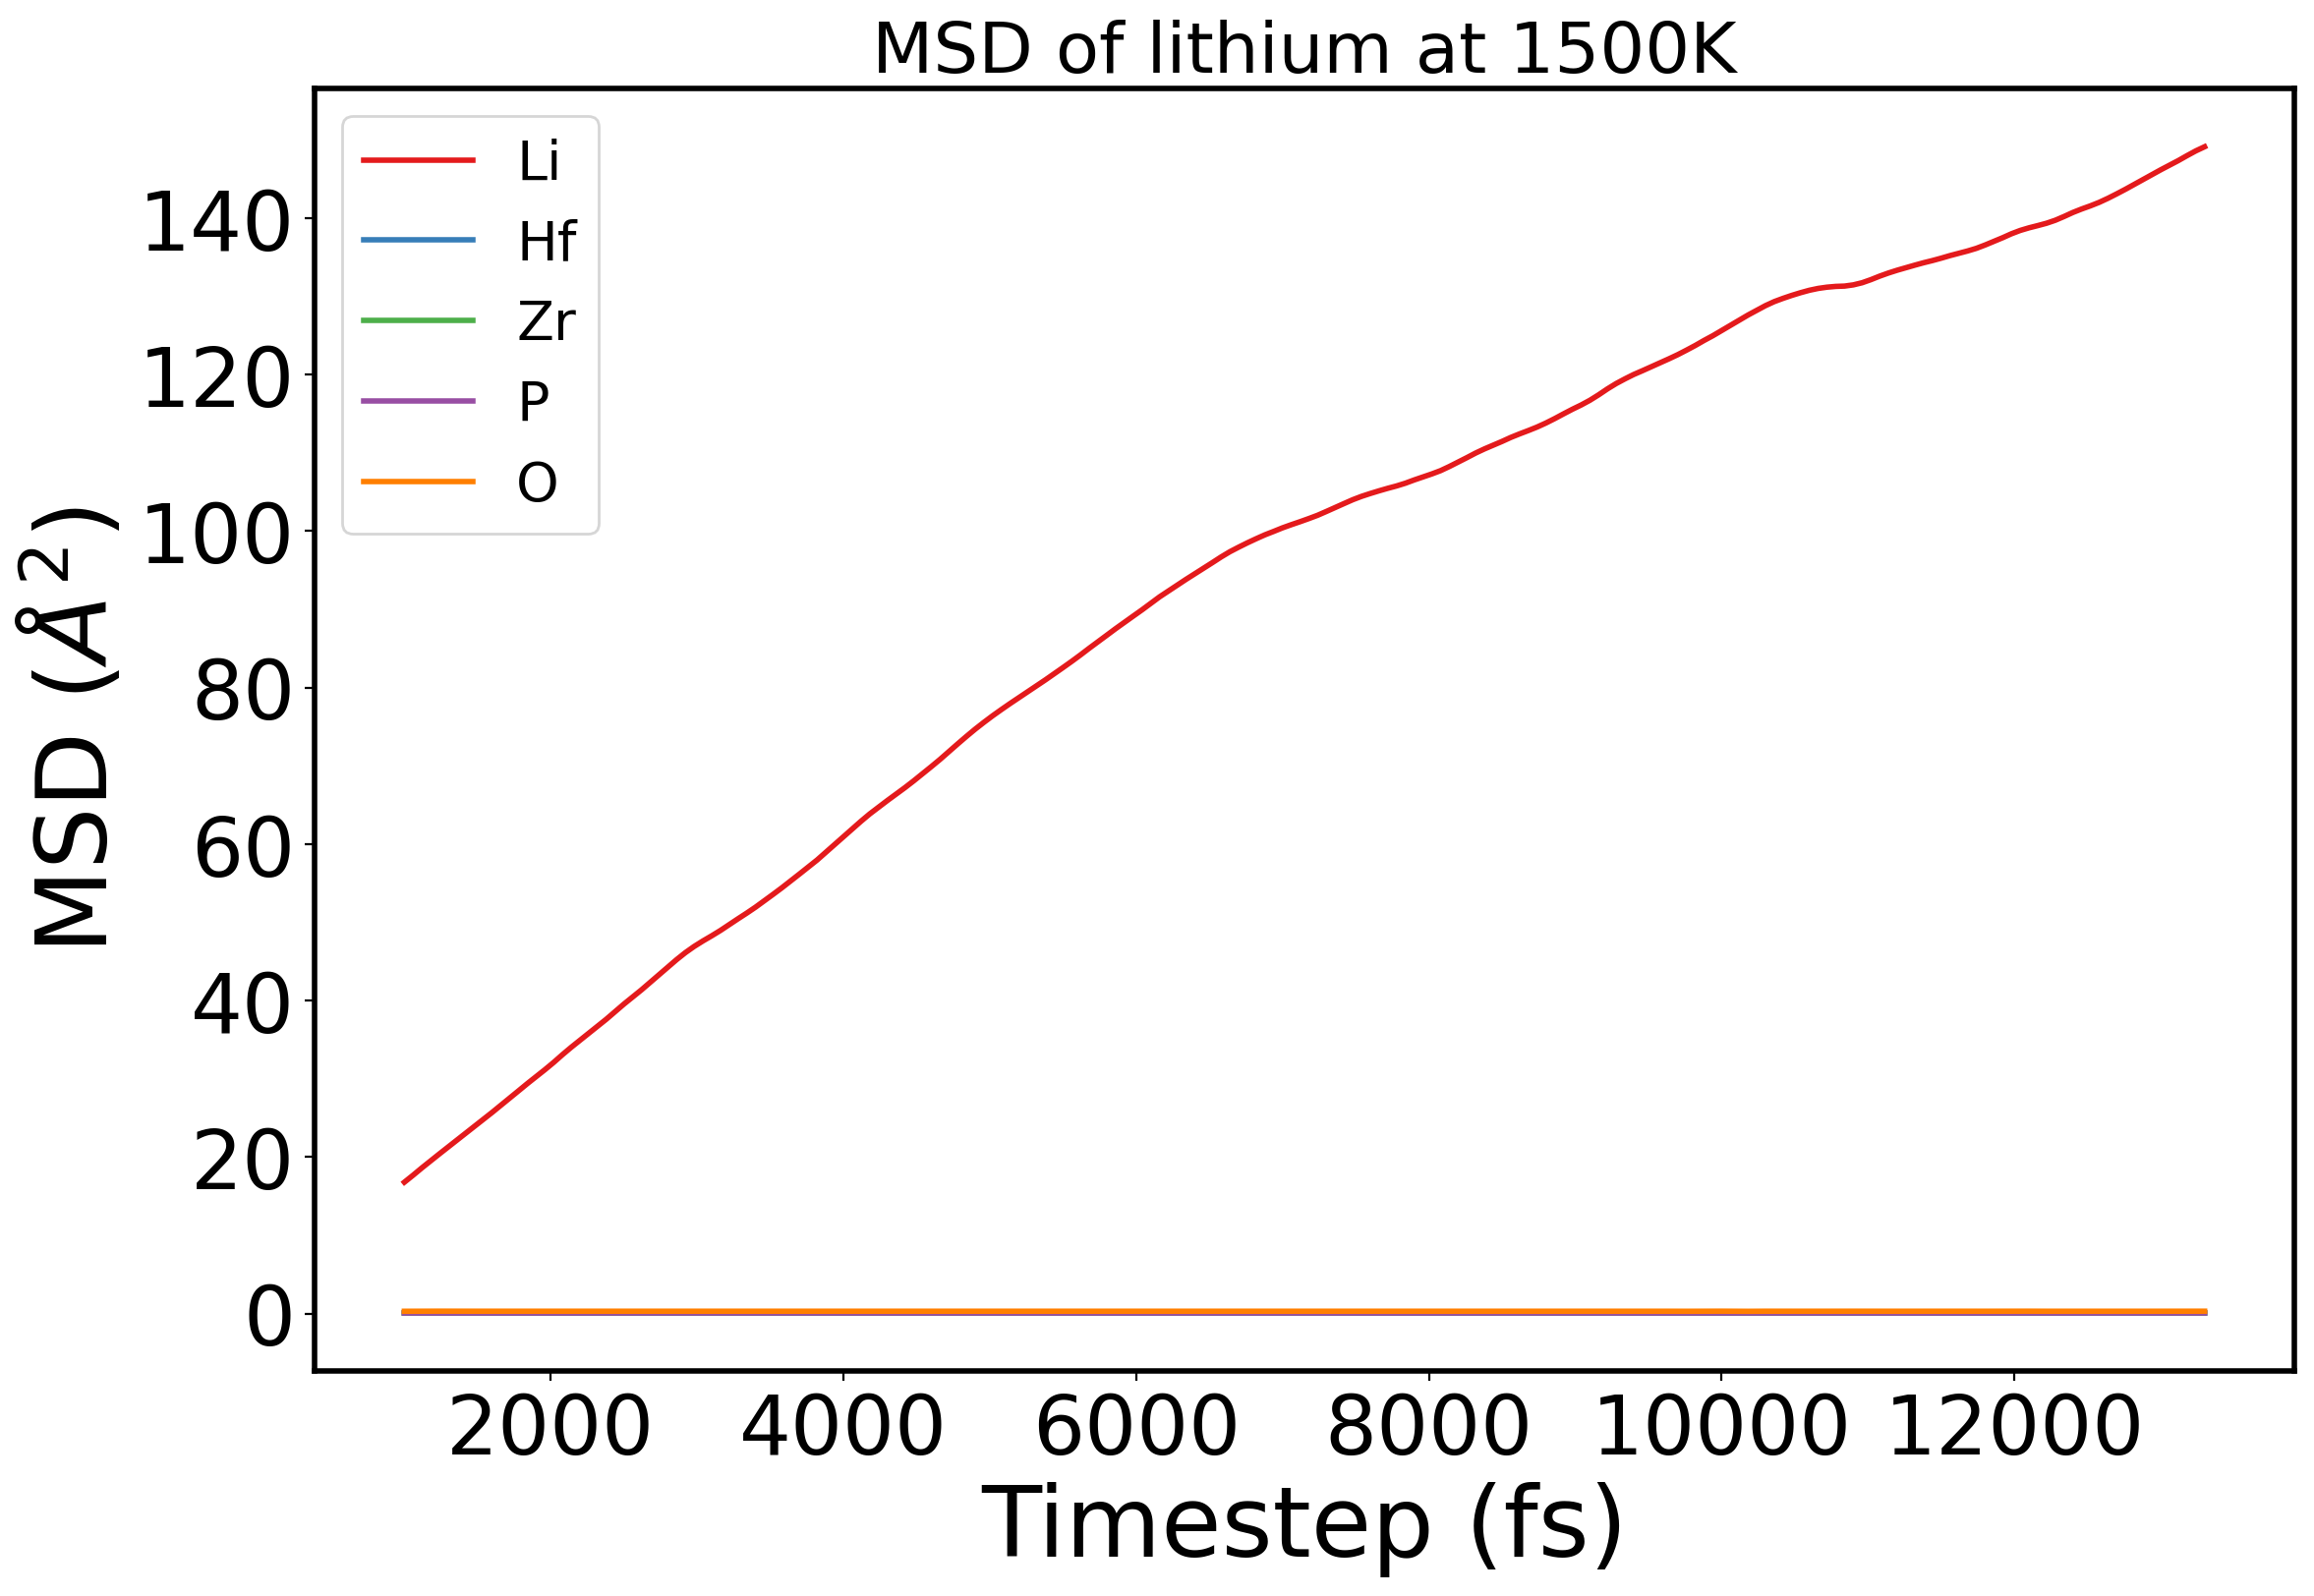

In [14]:
for temp in temperatures:
    # temp=900
    plt = analyzers[temp].get_msd_plot(mode="species")  # mode="sites"
    plt.title("MSD of lithium at {}K".format(temp), fontsize=26)
    plt.savefig(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/sites_{temp}K_smooth.png', bbox_inches='tight', dpi=600, format='png')

In [15]:
# for temp in temperatures:
#     plt = analyzers[temp].get_msd_plot(mode="sites")  # mode="sites"
#     plt.title("MSD of lithium at {}K".format(temp), fontsize=26)
#     plt.savefig(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/sites_{temp}K_smooth_1.png', bbox_inches='tight', dpi=600, format='png')

In [16]:
analyzers.keys()

odict_keys([1100, 1300, 1500])

In [17]:
temperatures = [1300,1100,1500]
diffusivities = [analyzers[d].diffusivity for d in [j for j in temperatures]]
N_specie = len([i for i in structures[temperatures[0]][0].sites if i.species_string == 'Li'])
diffusivity_errors1 = []
N_eff_hopping = []

for i, temp in enumerate(temperatures):
    print(temp)
    N_eff = N_specie*max(analyzers[temp].msd)/(Li_Li_distance[i]*Li_Li_distance[i])
    N_eff_hopping.append(int(N_eff))
    diffusivity_errors1.append(diffusivities[i]*(3.43/N_eff**0.5+0.04)) 

1300
1100
1500


In [384]:
# analyzers[300]

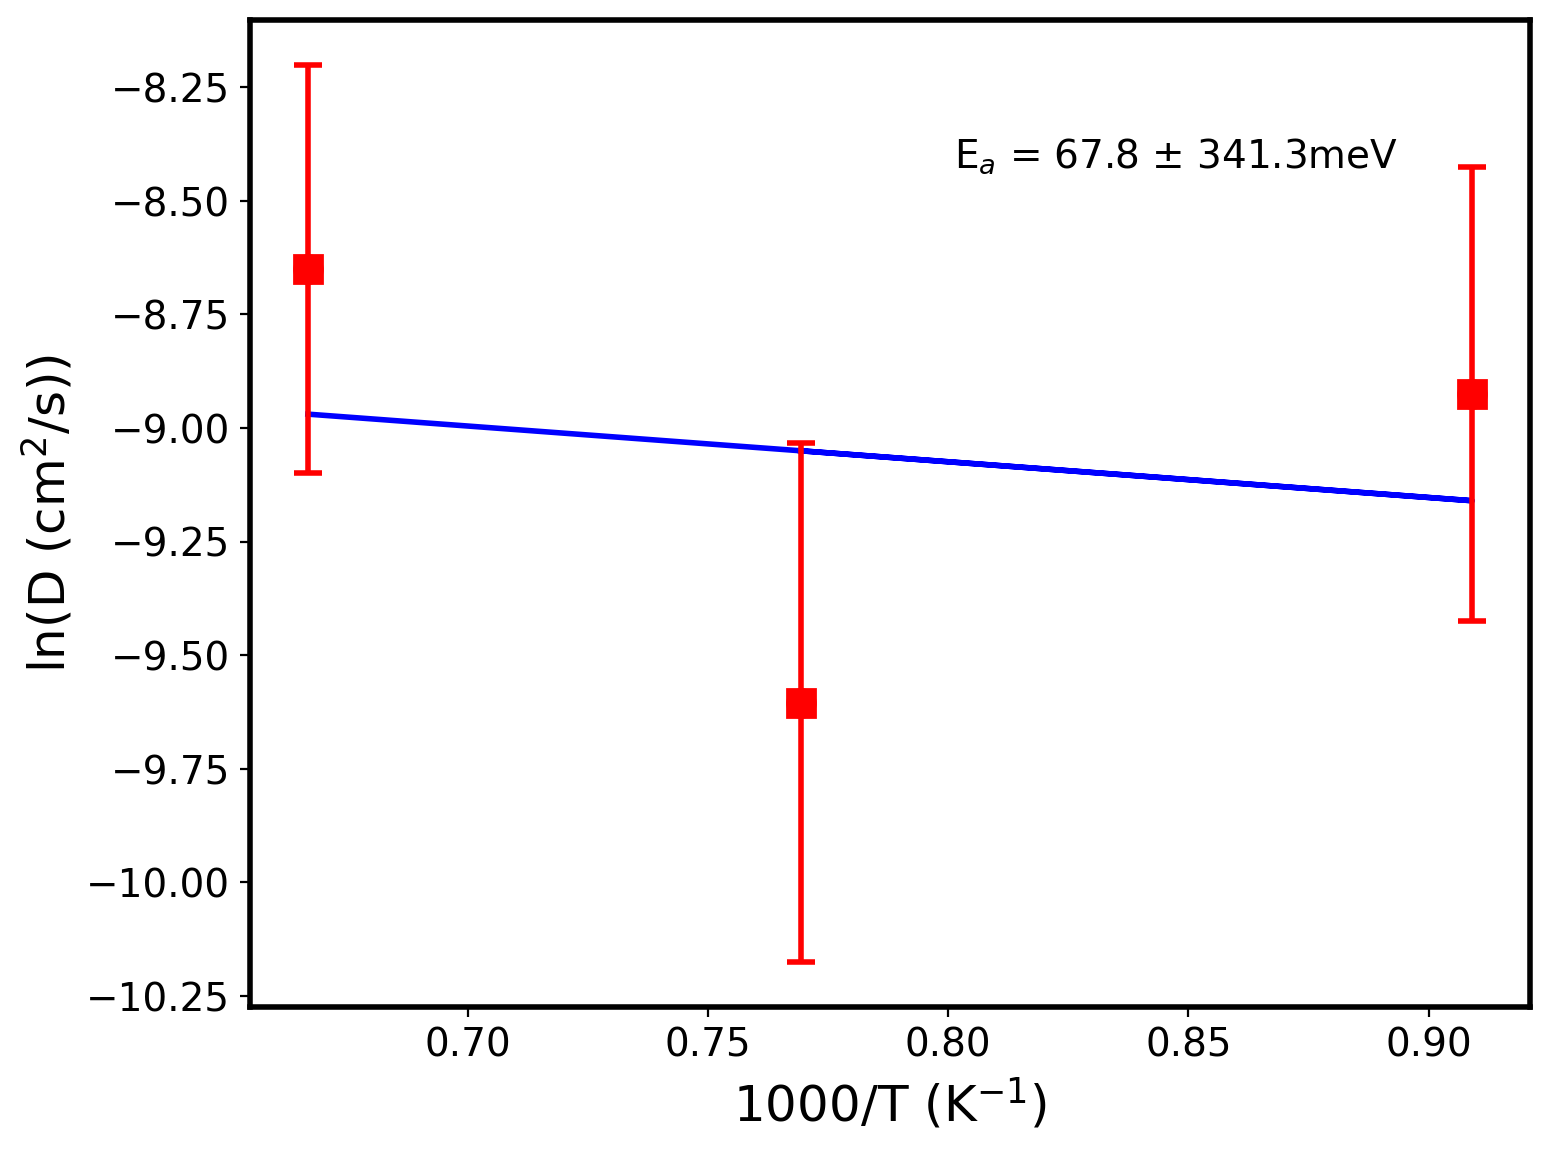

In [18]:
diff_errors1 = np.log10(np.array(diffusivities)+np.array(diffusivity_errors1))-np.log10(np.array(diffusivities))
plt = get_arrhenius_plot(temperatures, diffusivities, diff_errors1)
plt.savefig(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/Arrhenius plot with effective hopping deviation.png', bbox_inches='tight', dpi=600, format='png')


Stand deviation is [1.7538651960540024e-06, 1.1237801969277087e-06, 3.8806420851543417e-07, 4.410200053945567e-07]



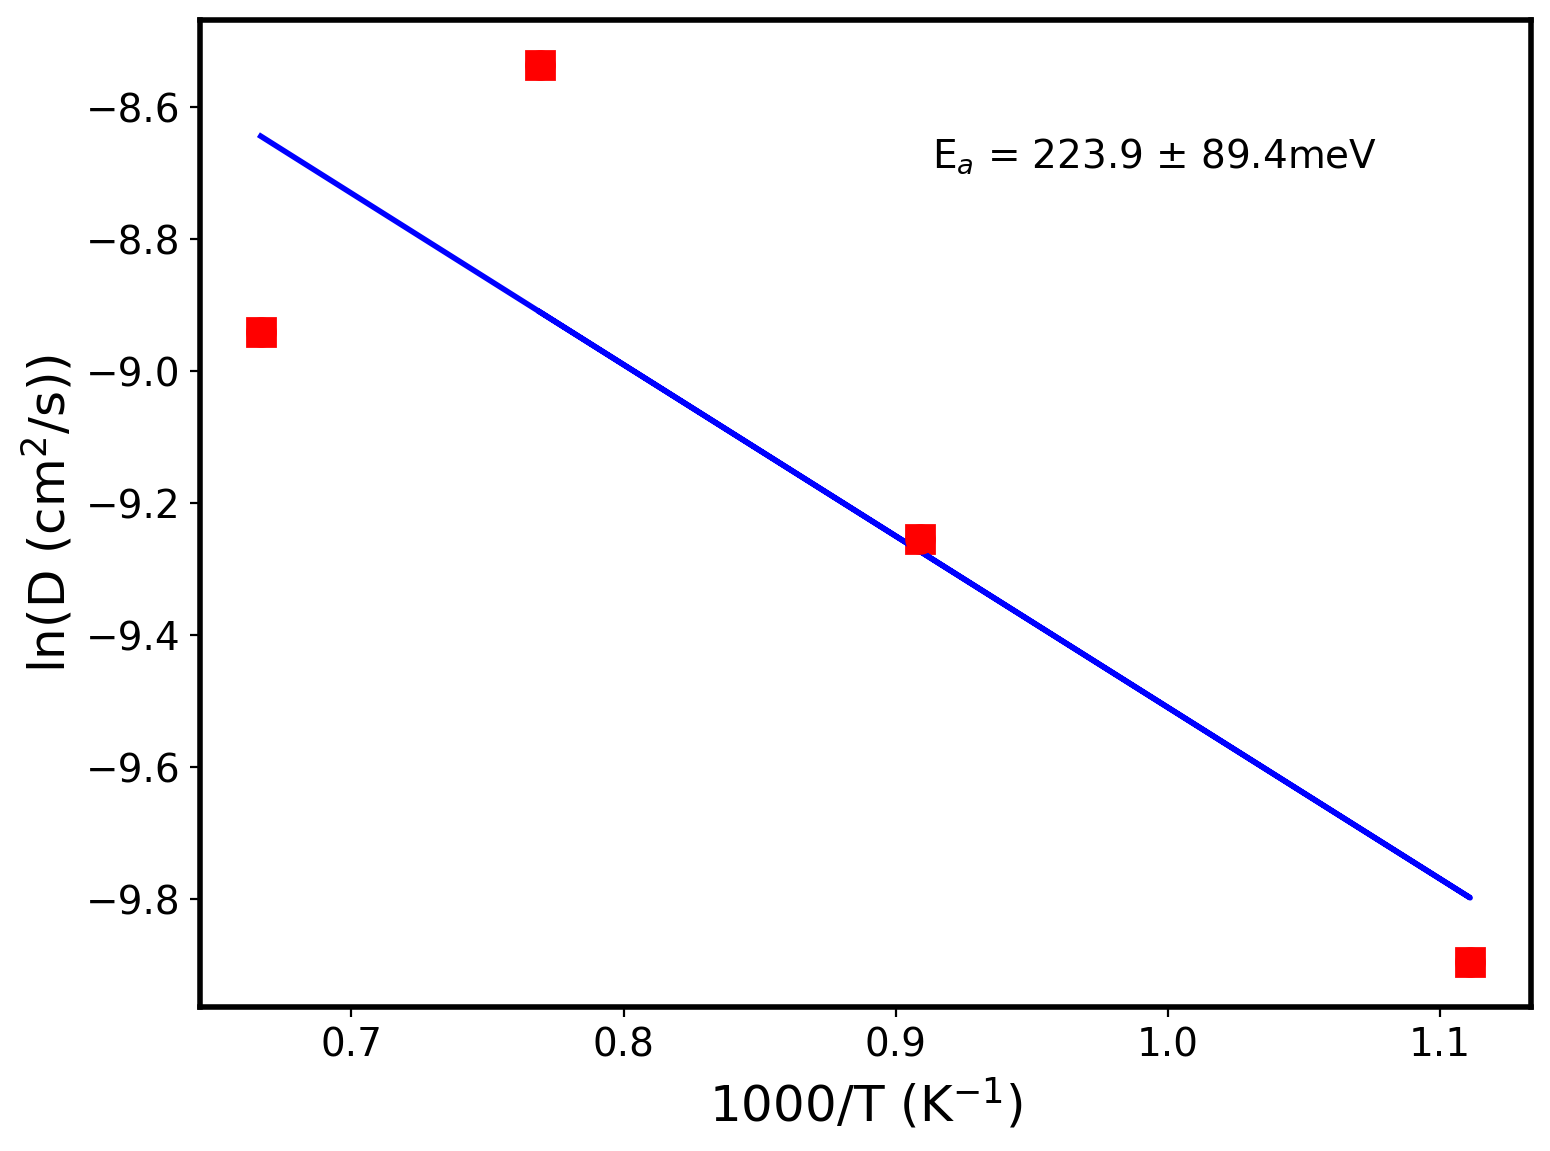

In [386]:
# diffusivities = [d.diffusivity for d in analyzers.values()]
diffusivity_errors2 = []

for i in temperatures:
    de = analyzers[i].get_summary_dict()['D_sigma']
    diffusivity_errors2.append(de)   
print('')
print('Stand deviation is {}'.format(diffusivity_errors2))
print('')
diff_errors2 = diffusivity_errors2
plt = get_arrhenius_plot(temperatures, diffusivities, diff_errors2)
plt.savefig(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/Arrhenius plot with stand deviation.png', bbox_inches='tight', dpi=600, format='png')

In [387]:
b = []
for i in range(len(temperatures)):
    a = {}
    a['temperature(K)'] = temperatures[i]
    a['Tracer diffusivity coefficient (cm2/s)'] = diffusivities[i]
    a['Effective hopping deviation'] = diffusivity_errors1[i]
    a['Tracer diffusivity stand deviation'] = analyzers[temperatures[i]].get_summary_dict()['D_sigma']
    a['Charge diffusivity coefficient (cm2/s)'] = analyzers[temperatures[i]].get_summary_dict()['D_charge']
    a['Charge diffusivity stand deviation'] = analyzers[temperatures[i]].get_summary_dict()['D_charge_sigma']
    a['Conductivity (mS/cm)'] = analyzers[temperatures[i]].get_summary_dict()['S']
    a['Conductivity stand deviation'] = analyzers[temperatures[i]].get_summary_dict()['S_sigma']
    a['Charge conductivity (mS/cm)'] = analyzers[temperatures[i]].get_summary_dict()['S_charge']
    a['Tracer diffusivity x, y, z components  (mS/cm)'] = analyzers[temperatures[i]].get_summary_dict()['D_components']
    a['Conductivity x, y, z components  (mS/cm)'] = analyzers[temperatures[i]].get_summary_dict()['S_components']
    a['Max framework displacement (angstrom)'] = analyzers[temperatures[i]].get_summary_dict()['max_framework_displacement']
    a['Haven ratio'] = analyzers[temperatures[i]].get_summary_dict()['Haven_ratio']
    a['Li-Li average distance'] = Li_Li_distance[i]
    a['Number of effective hopping for each temperature'] = N_eff_hopping[i]
    b.append(a)
pd.DataFrame(b).to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/Temperature dependent diffusivity details.csv',index=None)
pd.DataFrame(b)

,temperature(K),Tracer diffusivity coefficient (cm2/s),Effective hopping deviation,Tracer diffusivity stand deviation,Charge diffusivity coefficient (cm2/s),Charge diffusivity stand deviation,Conductivity (mS/cm),Conductivity stand deviation,Charge conductivity (mS/cm),"Tracer diffusivity x, y, z components (mS/cm)","Conductivity x, y, z components (mS/cm)",Max framework displacement (angstrom),Haven ratio,Li-Li average distance,Number of effective hopping for each temperature
0,1300,0.000196,0.000335,1.753865e-06,0.000224,2.414146e-06,1193.052156,10.651759,1358.731129,"[0.00020191359084922135, 0.00025673331944036, ...","[1226.2829299441848, 1559.2198913084462, 793.6...",1.346231,0.878063,8.73,4
1,1100,0.000096,0.000233,1.123780e-06,0.000124,2.266106e-06,687.023441,8.065981,891.400827,"[0.00015252110741307567, 7.247954979147574e-05...","[1094.7267933109301, 520.2250788079436, 446.11...",1.109083,0.770723,8.73,2
2,900,0.000050,0.000157,3.880642e-07,0.000072,3.287343e-07,442.125148,3.404314,629.138478,"[6.689975778078834e-05, 4.4459228154140236e-05...","[586.8816338195993, 390.02091073270077, 349.47...",1.000362,0.702747,8.73,1
3,1500,0.000131,0.000267,4.410200e-07,0.000143,1.408916e-06,689.022432,2.321323,750.444951,"[0.00016218218416149934, 0.0001692738086951794...","[853.6510299096954, 890.9780188031278, 322.438...",1.360031,0.918152,8.73,2


In [388]:
rts = get_extrapolated_conductivity(temperatures, diffusivities, new_temp=300, 
                                    structure=analyzers[min(temperatures)].structure, species="Li")
dc = get_extrapolated_diffusivity(temperatures, diffusivities, new_temp=300)

Ea, d0, error_Ea = fit_arrhenius(temperatures,diffusivities)

print('***********************************************************************')
print("  Prefactor D0 is {} cm$^2$/s ".format(d0))
print('***********************************************************************')
print("  Ionic conductivity at 300 K is {} mS/cm ".format(round(rts, 3)))
print('***********************************************************************')
print("  Ionic diffusion coefficient at 300 K is {} cm$^2$/s ".format(dc))
print('***********************************************************************')
print('')

c = {}
d = []
c['Lithium ionic conductivity at 300 K (mS/cm)'] = rts
c['Lithium ionic diffusion coefficient at 300 K (cm$^2$/s)'] = dc
c['Prefactor D0 (cm$^2$/s)'] = d0
d.append(c)
pd.DataFrame(d).to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/300K ionic conductivity and diffusion coefficient.csv',index=None)
pd.DataFrame(d)

***********************************************************************
  Prefactor D0 is 0.0009960710276862208 cm$^2$/s 
***********************************************************************
  Ionic conductivity at 300 K is 4.545 mS/cm 
***********************************************************************
  Ionic diffusion coefficient at 300 K is 1.7268432145095114e-07 cm$^2$/s 
***********************************************************************



,Lithium ionic conductivity at 300 K (mS/cm),Lithium ionic diffusion coefficient at 300 K (cm$^2$/s),Prefactor D0 (cm$^2$/s)
0,4.544647,1.726843e-07,0.000996


In [39]:
from pymatgen.analysis.diffusion.aimd.pathway import ProbabilityDensityAnalysis

temp1 = 900
# trajectories = [s.frac_coords for s in analyzers[temp1].get_drift_corrected_structures()]
pda = ProbabilityDensityAnalysis.from_diffusion_analyzer(analyzers[temp1], interval=0.5,species='Li')
pda.to_chgcar(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/{temp1}/CHGCAR.vasp") 

KeyError: 900

In [132]:
from pymatgen.analysis.diffusion.aimd.pathway import ProbabilityDensityAnalysis

temp1 = 300
# trajectories = [s.frac_coords for s in analyzers[temp1].get_drift_corrected_structures()]
pda = ProbabilityDensityAnalysis.from_diffusion_analyzer(analyzers[temp1], interval=0.5,species='Li')
pda.to_chgcar(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/{compund_type}/{system}/{aimd_type}/{temp1}/CHGCAR.vasp") 

KeyError: 300